In [1]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt

todos_pontos_linha = pd.read_csv("2022_03_08_pontosLinha.csv")

tipo_linhas_cabral = None
tipo_linhas_portao = None
tipo_linhas_pinheirinho = None
tipo_linhas_boqueirao = None
tipo_linhas_campina_do_siqueira = None
tipo_linhas_capao_da_imbuia = None
todos_tipos = None

def get_pontos_linha(codigo_linha: str, id_itineratio: int) -> pd.core.frame.DataFrame:
    return todos_pontos_linha.query("COD == @codigo_linha and ITINERARY_ID == @id_itineratio").sort_values("SEQ")

def add_pontos_no_grafo(grafo: nx.classes.graph.Graph, pontos_linha: pd.core.frame.DataFrame) -> None:
    for row in pontos_linha.itertuples(index=False):
        NOME = getattr(row, 'NOME')
        NUM = getattr(row, 'NUM')
        SEQ = getattr(row, 'SEQ')
        SENTIDO = getattr(row, 'SENTIDO')
        ITINERARY_ID = getattr(row, 'ITINERARY_ID')
        COD = getattr(row, 'COD')
        #Esse linha garante que os terminais não são duplicados.
        #Para isso a informação referente a linha, que consta no nome do ponto, é removida.
        ID = get_id_ponto(NOME, COD, NUM)
        NOME = ID if 'Terminal' in NOME else NOME
        if 'Terminal' in NOME:
            NOME = ID
            #Codigo arbitrário para facilitar a identificação de terminais.
            COD = str(999)

        grafo.add_node(ID, nome=NOME, num=NUM, seq=SEQ, sentido=SENTIDO, itinerario_id=ITINERARY_ID, cod=COD)            

def add_arestas_entre_pontos(grafo: nx.classes.graph.Graph, pontos_linha: pd.core.frame.DataFrame) -> None:
    #Os indices das linhas do dataframe não são sequenciais, visto que, o dataframe é resultado
    #de uma query.
    indexes = pontos_linha.index.values.tolist()
    capacidade_linha = get_capacidade_por_codigo_linha(pontos_linha.loc[indexes[0], 'COD'])
    for i in range(len(pontos_linha)-1):
        source = get_id_ponto(ponto_info=pontos_linha.loc[indexes[i]])
        target = get_id_ponto(ponto_info=pontos_linha.loc[indexes[i+1]])
        grafo.add_edge(source, target, weight=capacidade_linha)

def get_linhas_por_terminal(nome_terminal: str) -> pd.core.frame.DataFrame:
    nome_terminal = f"{nome_terminal} -"
    codigos_linha = todos_pontos_linha.query("NOME.str.contains(@nome_terminal)", engine="python").groupby("COD")
    return list(codigos_linha.groups.keys())

def get_itinerarios_por_linha(codigo_linha: str) -> list:
    return list(todos_pontos_linha.query("COD == @codigo_linha").sort_values("ITINERARY_ID").groupby("ITINERARY_ID").groups.keys())

def get_itinerario_com_terminal(codigo_linha: str) -> list:
    terminal = 'Terminal '
    return list(todos_pontos_linha.query("COD == @codigo_linha and NOME.str.contains(@terminal)", engine="python").sort_values("ITINERARY_ID").groupby("ITINERARY_ID").groups.keys())

def get_id_ponto(nome_ponto: str = None, codigo_ponto: str = None, numero_ponto: int = 0, ponto_info: pd.core.series.Series = None) -> str:
    if ponto_info is not None:
        nome_ponto = ponto_info['NOME']
        codigo_ponto = ponto_info['COD']
        numero_ponto = ponto_info['NUM']

    ID = None
    if 'Terminal' in nome_ponto:
        ID = nome_ponto.split(' - ')[0]
    else:
        ID = f"{codigo_ponto}-{str(numero_ponto)}"
        
    return ID

def get_capacidade_por_tipo_linha(tipo_linha: str) -> int:
    tipo_linha = tipo_linha.upper() if tipo_linha is not None else None
    # Capacidade de acordo com a categoria do veículo.
    # Fonte: https://www.urbs.curitiba.pr.gov.br/transporte/rede-integrada-de-transporte/42
    # Cada linha pode apresentar diferentes modelos de veículos utilizados. Comentários foram adicionados indicando o modelo escolhido.
    capacidade = {
        'LIGEIRÃO': 250,
        'EXPRESSO': 250,#Biarticulado
        'LINHA DIRETA': 110,#Padron
        'INTERBAIRROS': 140,#Articulado
        'ALIMENTADOR': 85,#Comum
        'TRONCAL': 85,#Comum
        'CONVENCIONAL': 85#Comum
    }
    
    return capacidade[tipo_linha]

def get_capacidade_por_codigo_linha(codigo_linha: str) -> str:
    tipo = todos_tipos[codigo_linha]
    return get_capacidade_por_tipo_linha(tipo)

def set_tipo_linhas() -> None:
    # Para quase todos os dados abaixo a fonte foi https://www.urbs.curitiba.pr.gov.br/pdf/transporte/rit/Linhas_x_Empresas_Operadoras_codigo.pdf
    # As exceções estão sinalizadas com comentários

    global tipo_linhas_cabral, tipo_linhas_portao, tipo_linhas_pinheirinho, tipo_linhas_boqueirao, tipo_linhas_campina_do_siqueira, tipo_linhas_capao_da_imbuia
    global todos_tipos

    tipo_linhas_cabral = {
        '020':'INTERBAIRROS',
        '021':'INTERBAIRROS',
        '022':'LINHA DIRETA',
        '023':'LINHA DIRETA',
        '200':'LIGEIRÃO',
        '202':'EXPRESSO',
        '203':'EXPRESSO',
        '207':'TRONCAL',
        '210':'LINHA DIRETA',
        '211':'ALIMENTADOR',
        '212':'ALIMENTADOR',
        '213':'ALIMENTADOR',
        '214':'ALIMENTADOR',
        '216':'ALIMENTADOR',
        '245':'ALIMENTADOR',
        '607':'LINHA DIRETA',
        '700':'LINHA DIRETA'
    }

    tipo_linhas_portao = {
        '022':'LINHA DIRETA', 
        '023':'LINHA DIRETA', 
        '024':'LINHA DIRETA', 
        '050':'INTERBAIRROS', 
        '216':'ALIMENTADOR', 
        '611':'ALIMENTADOR', 
        '612':'ALIMENTADOR', 
        '615':'ALIMENTADOR', 
        '616':'ALIMENTADOR', 
        '700':'LINHA DIRETA', 
        'X35':'LINHA DIRETA'
    }


    tipo_linhas_pinheirinho = {
        '040':'INTERBAIRROS',
        '060':'INTERBAIRROS',
        '350':'EXPRESSO',
        '502':'EXPRESSO',
        '507':'LINHA DIRETA',
        '508':'LINHA DIRETA',
        '527':'LINHA DIRETA', # Informação retirada de https://www.urbs.curitiba.pr.gov.br/pdf/transporte/rit/linhas_diretas_editada.pdf
        '528':'ALIMENTADOR',
        '550':'LIGEIRÃO',
        '600':'ALIMENTADOR',
        '602':'EXPRESSO',
        '603':'EXPRESSO',
        '610':'LINHA DIRETA',
        '617':'ALIMENTADOR',
        '630':'ALIMENTADOR',
        '631':'ALIMENTADOR',
        '633':'ALIMENTADOR',
        '635':'ALIMENTADOR',
        '636':'ALIMENTADOR',
        '637':'ALIMENTADOR',
        '638':'ALIMENTADOR',
        '639':'ALIMENTADOR',
        '640':'ALIMENTADOR',
        '641':'ALIMENTADOR',
        '642':'ALIMENTADOR',
        '643':'ALIMENTADOR',
        '644':'ALIMENTADOR',
        '646':'ALIMENTADOR',
        '649':'ALIMENTADOR',
        '650':'ALIMENTADOR',
        '655':'ALIMENTADOR',
        '659':'ALIMENTADOR',
        '680':'ALIMENTADOR',
        '681':'ALIMENTADOR',
        '690':'ALIMENTADOR',
        '700':'LINHA DIRETA',
        '772':'ALIMENTADOR',
        'X11':'EXPRESSO',
        'X20':'EXPRESSO',
        'X35':'LINHA DIRETA'
    }

    ## As linhas 539 . Optou-se por deixá-las todas como 'ALIMENTADOR'. 

    tipo_linhas_boqueirao = {
        '335':'ALIMENTADOR',
        '500':'LIGEIRÃO',
        '502':'EXPRESSO',
        '503':'EXPRESSO',
        '505':'LINHA DIRETA',
        '507':'LINHA DIRETA',
        '508':'LINHA DIRETA',
        '513':'ALIMENTADOR',
        '515':'ALIMENTADOR',
        '527':'LINHA DIRETA', # Informação retirada de https://www.urbs.curitiba.pr.gov.br/pdf/transporte/rit/linhas_diretas_editada.pdf
        '528':'ALIMENTADOR',
        '531':'ALIMENTADOR',
        '532':'ALIMENTADOR',
        '533':'ALIMENTADOR',
        '534':'ALIMENTADOR',
        '535':'ALIMENTADOR',
        '536':'ALIMENTADOR',
        '539':'ALIMENTADOR', # Informação não disponível. Trata-se de suposição.
        '545':'ALIMENTADOR',
        '546':'LINHA DIRETA',
        '602':'EXPRESSO',
        'X12':'EXPRESSO'
    } # Informação retirada de https://www.urbs.curitiba.pr.gov.br/pdf/transporte/rit/expressos.pdf

    ## As linhas X02 e X31 não possuem caracterização do tipo de transporte. Optou-se por deixá-las todas como 'ALIMENTADOR'. 
    tipo_linhas_campina_do_siqueira = {
        '020':'INTERBAIRROS',
        '021':'INTERBAIRROS',
        '022':'LINHA DIRETA',
        '023':'LINHA DIRETA',
        '024':'LINHA DIRETA',
        '027':'INTERBAIRROS',
        '303':'EXPRESSO',
        '304':'LINHA DIRETA',
        '801':'TRONCAL',
        '811':'ALIMENTADOR',
        '812':'ALIMENTADOR',
        '814':'ALIMENTADOR',
        '816':'ALIMENTADOR',
        'X02':'ALIMENTADOR', # Informação não disponível. Trata-se de suposição.
        'X31':'ALIMENTADOR'# Informação não disponível. Trata-se de suposição.
    }

    tipo_linhas_capao_da_imbuia = {
        '020':'INTERBAIRROS', 
        '021':'INTERBAIRROS', 
        '022':'LINHA DIRETA', 
        '023':'LINHA DIRETA', 
        '302':'EXPRESSO', 
        '303':'EXPRESSO', 
        '304':'LINHA DIRETA', 
        '311':'ALIMENTADOR', 
        'X30':'LINHA DIRETA'
    } # Informação retirada de https://www.urbs.curitiba.pr.gov.br/pdf/transporte/rit/linhas_diretas_editada.pdf
    
    todos_tipos = tipo_linhas_cabral | tipo_linhas_portao | tipo_linhas_pinheirinho | tipo_linhas_boqueirao | tipo_linhas_campina_do_siqueira | tipo_linhas_capao_da_imbuia

def add_terminais_e_linhas(grafo: nx.classes.graph.Graph, terminais: list) -> None:
    for terminal in terminais:
        linhas = get_linhas_por_terminal(terminal)
        for codigo_linha in linhas:
            id_itinerario = get_itinerario_com_terminal(codigo_linha)[-1]#get_itinerarios_por_linha(codigo_linha)[-1]
            pontos = get_pontos_linha(codigo_linha, id_itinerario)
            #print(f"{codigo_linha} - {id_itinerario} - {len(pontos)}")
            add_pontos_no_grafo(grafo, pontos)
            add_arestas_entre_pontos(grafo, pontos)
    
set_tipo_linhas()

linhas = get_linhas_por_terminal("Terminal Cabral")
linhas

In [2]:
get_itinerario_com_terminal('550')

[772, 773]

In [3]:
grafo = nx.DiGraph()
terminais = [
    'Terminal Boqueirão',
    'Terminal Cabral',
    'Terminal Campina do Siqueira',
    'Terminal Capão da Imbuia',
    'Terminal Pinheirinho',
    'Terminal Portão']
add_terminais_e_linhas(grafo, terminais)

In [4]:
len(grafo.nodes())

1991

In [5]:
len(grafo.edges)

2086

In [6]:
nx.write_gml(grafo, 'Todos_Terminais-Directed.gml')

In [7]:
list(grafo.edges(data=True))

[('Terminal Boqueirão', '335-140480', {'weight': 85}),
 ('Terminal Boqueirão', '502-108111', {'weight': 250}),
 ('Terminal Boqueirão', 'Terminal Carmo', {'weight': 110}),
 ('Terminal Boqueirão', '507-109006', {'weight': 110}),
 ('Terminal Boqueirão', '513-150431', {'weight': 85}),
 ('Terminal Boqueirão', '515-140296', {'weight': 85}),
 ('Terminal Boqueirão', '545-150026', {'weight': 85}),
 ('Terminal Boqueirão', '602-108095', {'weight': 250}),
 ('Terminal Boqueirão', 'X12-108111', {'weight': 250}),
 ('335-140480', '335-140482', {'weight': 85}),
 ('335-140482', '335-140484', {'weight': 85}),
 ('335-140484', '335-140486', {'weight': 85}),
 ('335-140486', '335-140488', {'weight': 85}),
 ('335-140488', '335-140490', {'weight': 85}),
 ('335-140490', '335-140492', {'weight': 85}),
 ('335-140492', '335-140494', {'weight': 85}),
 ('335-140494', '335-140496', {'weight': 85}),
 ('335-140496', '335-140498', {'weight': 85}),
 ('335-140498', '335-140500', {'weight': 85}),
 ('335-140500', '335-14050

# Métricas do Grafo

### Número de nós

In [8]:
grafo.number_of_nodes()

1991

### Número de edges

In [9]:
print(grafo.number_of_edges())

2086


### Centralidade de grau

In [10]:
# Calculando a centralidade de grau
degree_centrality = nx.degree_centrality(grafo)

# Colocando degree_centrality em ordem decrescente
degree_centrality = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)

# Exibindo a centralidade de grau de cada nó
degree_centrality

[('Terminal Pinheirinho', 0.02412060301507538),
 ('Terminal Capão Raso', 0.0135678391959799),
 ('Terminal Boqueirão', 0.01206030150753769),
 ('Terminal Campina do Siqueira', 0.01155778894472362),
 ('Terminal Cabral', 0.01155778894472362),
 ('Terminal Sítio Cercado', 0.009547738693467337),
 ('Terminal Hauer', 0.009045226130653268),
 ('Terminal Capão da Imbuia', 0.008542713567839196),
 ('Terminal Portão', 0.008542713567839196),
 ('Terminal Carmo', 0.006030150753768845),
 ('Terminal Campo Comprido', 0.0035175879396984926),
 ('Terminal Portão-202-Cabral/C.Raso-203-Sta.Cândida/C.Raso-603-Pinheirinho-Circular Sul(H)',
  0.0030150753768844224),
 ('Terminal Boa Vista', 0.0030150753768844224),
 ('Terminal CIC', 0.0030150753768844224),
 ('Terminal Fazendinha', 0.0025125628140703522),
 ('Terminal Portão-202-Cabral/C.Raso-203-Sta.Cândida/C.Raso-603-Pinheirinho-602-Circular Sul(AH)',
  0.0025125628140703522),
 ('Terminal Oficinas', 0.0025125628140703522),
 ('Terminal Guadalupe', 0.00201005025125628

### Centralidade de intermediação

In [11]:
# Calculando a centralidade de intermediação
betweenness_centrality = nx.betweenness_centrality(grafo)

# Colocando betweenness centrality em ordem decrescente
betweenness_centrality = sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True)

# Exibindo a centralidade de intermediação de cada nó
betweenness_centrality

[('Terminal Pinheirinho', 0.3506130788010796),
 ('Terminal Portão', 0.22334733833404075),
 ('Terminal Capão Raso', 0.21093603597002486),
 ('Terminal Campina do Siqueira', 0.16902823148759094),
 ('Terminal Hauer', 0.14838071705940406),
 ('Terminal Cabral', 0.12236926209731412),
 ('Terminal Sítio Cercado', 0.10977262717138393),
 ('Terminal Boqueirão', 0.10969048358938988),
 ('Terminal Capão da Imbuia', 0.08872833246170521),
 ('022-109077', 0.07108434749581646),
 ('Terminal Carmo', 0.06151013151899882),
 ('Terminal Fazendinha', 0.05363494192935517),
 ('023-109067', 0.041643865380194024),
 ('024-109067', 0.041643865380194024),
 ('023-109077', 0.04093494959294554),
 ('507-109006', 0.03985622767768787),
 ('Terminal Campo Comprido', 0.038377154753152384),
 ('022-109034', 0.03728484049205302),
 ('022-109065', 0.037229763700351935),
 ('507-109076', 0.03654631461311917),
 ('617-150331', 0.03469332585501666),
 ('617-160301', 0.03463824906331557),
 ('617-160078', 0.03458317227161448),
 ('617-16043

### Centralidade de proximidade

In [12]:
# Calculando a centralidade de proximidade
closeness_centrality = nx.closeness_centrality(grafo)

# Colocando closeness centrality em ordem decrescente
closeness_centrality = sorted(closeness_centrality.items(), key=lambda x: x[1], reverse=True)

# Exibindo a centralidade de proximidade de cada nó
closeness_centrality

[('Terminal Capão Raso', 0.05296961609164967),
 ('Terminal Pinheirinho', 0.052836160335769315),
 ('Terminal Portão', 0.05269522578098471),
 ('Terminal Hauer', 0.04988728226110791),
 ('020-170002', 0.04982528329930962),
 ('021-150169', 0.049817999433612765),
 ('Terminal CIC', 0.049810717697234254),
 ('502-108056', 0.0498088975957362),
 ('202-108056', 0.0498088975957362),
 ('603-108056', 0.0498088975957362),
 ('607-109071', 0.0498034380892405),
 ('507-109002', 0.049797979779436397),
 ('X20-108056', 0.04979616060869849),
 ('602-108057', 0.04979252266593047),
 ('023-109077', 0.049788885254675744),
 ('528-150331', 0.04976707194240645),
 ('617-150331', 0.04975798870240966),
 ('060-170983', 0.04974890877746396),
 ('350-108203', 0.04972404559321547),
 ('550-108203', 0.04972404559321547),
 ('600-150331', 0.04972404559321547),
 ('641-150331', 0.04972404559321547),
 ('642-150331', 0.04972404559321547),
 ('646-150331', 0.04972404559321547),
 ('655-150331', 0.04972404559321547),
 ('690-150331', 0.0

### Centralidade de autovetor

In [13]:
# Calculando a centralidade de autovetor
eigenvector_centrality = nx.eigenvector_centrality(grafo)

# Colocando betweenness centrality em ordem decrescente
eigenvector_centrality = sorted(eigenvector_centrality.items(), key=lambda x: x[1], reverse=True)

# Exibindo a centralidade de autovetor
eigenvector_centrality

[('Terminal Capão Raso', 0.2924597885326017),
 ('Terminal Portão', 0.26432154350937764),
 ('Terminal Pinheirinho', 0.26329458226887886),
 ('Terminal Sítio Cercado', 0.1587306367423538),
 ('Terminal Boqueirão', 0.14425179576734984),
 ('Terminal CIC', 0.12026533978543007),
 ('502-108056', 0.12005310440223792),
 ('507-109002', 0.12005310440223792),
 ('602-108057', 0.12005310440223792),
 ('020-170002', 0.12005310440223792),
 ('021-150169', 0.12005310440223792),
 ('023-109077', 0.12005310440223792),
 ('202-108056', 0.12005310440223792),
 ('607-109071', 0.12005310440223792),
 ('603-108056', 0.12005310440223792),
 ('X20-108056', 0.12005310440223792),
 ('Terminal Carmo', 0.11675119298195819),
 ('022-109066', 0.10850959730804045),
 ('216-150023', 0.10850959730804045),
 ('700-109002', 0.10850959730804045),
 ('024-109066', 0.10850959730804045),
 ('050-170030', 0.10850959730804045),
 ('502-108064', 0.10808211053881826),
 ('508-109075', 0.10808211053881826),
 ('527-109075', 0.10808211053881826),
 (

### Coeficiente de clusterização

In [14]:
# Exibindo o coeficiente de clusterização
print(nx.average_clustering(nx.Graph(grafo)))

7.088488952529308e-06


### Distribuição de graus

Text(0, 0.5, 'Numero de nós')

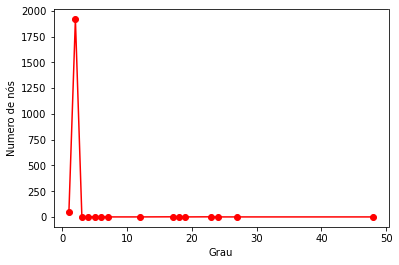

In [15]:
dicDegree = dict(grafo.degree() )
valores = sorted(set(dicDegree.values()))
valores

hist = [list(dicDegree.values()).count(x) for x in valores]


plt.plot(valores, hist, 'ro-') 

plt.xlabel('Grau')
plt.ylabel('Numero de nós')

### Topologia da rede

nx.draw(grafo, with_labels=False)

#### Circular Layout

# No layout circular, todos os nós são colocados na circunferência de um círculo. 
# As conexões de cada nó para outros nós conectados são indicadas pelas linhas que conectam esses pontos.
# Isso ajuda a mostrar a distribuição de densidade das conexões e a distância entre os nós de conexão.


plt.figure(figsize=(10,10))
pos = nx.circular_layout(grafo)
nx.draw_networkx(grafo, pos, with_labels=False, edge_color='.4')
 
plt.axis('off')
plt.tight_layout();

#### Random Layout

# Neste layout os nós são colocados aleatoriamente dentro de uma área.
# As conexões entre os nós são desenhadas com linhas. O layout ajuda a entender a distribuição aleatória da rede.

plt.figure(figsize=(50,50))
pos = nx.random_layout(grafo)
nx.draw_networkx(grafo, pos, with_labels=False)
 
plt.axis('off')
plt.tight_layout();

### Spring Layout

# O Spring Layout ajuda a entender se existem nós isolados no gráfico. 
# Também dá pistas sobre o número de componentes conectados.
# O alphaparâmetro mostra a opacidade da cor do nó.

plt.figure(figsize=(10,10))
nx.draw_networkx(grafo, alpha=0.7, with_labels=False)
plt.axis('off')
plt.tight_layout();